# Technical Interview

Packages used:
- Napari
- Matplotlib

In [1]:
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import napari
from stackview import insight
from napari.utils import nbscreenshot

def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(projection_x, plot=axs[0], labels=labels)
    cle.imshow(projection_y, plot=axs[1], labels=labels)
    cle.imshow(projection_z, plot=axs[2], labels=labels)
    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_hist(image, bins=256, log=True, title="Histogram of intensities"):
    """
    Plot histogram of pixel intensities for an image or volume.
    
    Parameters
    ----------
    image : ndarray
        2D or 3D numpy array of image data
    bins : int, optional
        Number of histogram bins (default: 256)
    log : bool, optional
        Whether to use log scale on y-axis (default: True)
    title : str, optional
        Title for the plot
    """
    values = image.ravel()
    print('Min intensity:', np.min(values))
    print('Max intensity:', np.max(values))
    print('Mean intensity:', np.mean(values))
    
    plt.figure(figsize=(6,4))
    plt.hist(values, bins=bins, color='gray', alpha=0.7)
    plt.title(title)
    plt.xlabel("Intensity value")
    plt.ylabel("Pixel count")
    
    if log:
        plt.yscale("log")
    
    plt.tight_layout()
    plt.show()



## 1. Data Formats
1. Inspect the OME-Zarr and retrieve key metadata using iohub (i.e, array shapes, scale, channel names, chunk sizes, etc). Tell us what method you used and save them in a text file.

I played around and explored a bit the structure to extract the key metadata then used chatgpt to make a function out of what I had and the formatting for a readable text file

In [2]:
from iohub import open_ome_zarr
import json

def save_ome_zarr_metadata_readable(zarr_path: str, output_file: str):
    """
    Extract key metadata from an OME-Zarr and save as a readable text file.
    Includes axes, shape, chunks, voxel sizes, channels with extra metadata, NGFF, and OMERO metadata.
    """
    with open_ome_zarr(zarr_path, mode="r", layout="auto") as pos:
        arr = pos.data
        meta_dict = pos.metadata.model_dump()
        pos.print_tree()
        # Axis info
        axes_info = pos.metadata.multiscales[0].axes
        axis_table = []
        for ax in axes_info:
            axis_table.append(f"{ax.name:<3} | type: {ax.type:<7} | unit: {getattr(ax,'unit',None)}")
        
        # Shape and chunks
        shape = arr.shape
        chunks = arr.chunks
        
        # Voxel size (if available)
        voxel_size = None
        if "multiscales" in meta_dict:
            try:
                voxel_size = meta_dict["multiscales"][0]["datasets"][0]["coordinate_transformations"][0]["scale"]
            except (KeyError, IndexError, TypeError):
                voxel_size = None
        
        # Channels
        channels = pos.channel_names
        channel_details = []
        if "omero" in meta_dict and "channels" in meta_dict["omero"]:
            for ch in meta_dict["omero"]["channels"]:
                channel_details.append(
                    f"Label: {ch.get('label', '')}, Color: {ch.get('color','')}, "
                    f"Active: {ch.get('active','')}, Coefficient: {ch.get('coefficient','')}"
                )
        
        # OMERO metadata (if available)
        omero_obj = getattr(pos.metadata, "omero", None)
        omero_metadata = omero_obj.model_dump() if omero_obj else None
        
        # Build readable text
        lines = []
        lines.append("=== OME-Zarr Metadata Summary ===\n")
        lines.append("Axes:")
        lines.extend(axis_table)
        lines.append("\nShape: " + str(shape))
        lines.append("Chunks: " + str(chunks))
        if voxel_size:
            lines.append("Voxel size (TCZYX): " + str(voxel_size))
        lines.append("\nChannels:")
        lines.append(", ".join(channels))
        lines.append("\nChannel details:")
        lines.extend(channel_details if channel_details else ["None"])
        lines.append("\n--- NGFF Metadata ---")
        lines.append(json.dumps(meta_dict, indent=2))
        lines.append("\n--- OMERO Metadata ---")
        lines.append(json.dumps(omero_metadata, indent=2) if omero_metadata else "None")
        
        # Write to file
        with open(output_file, "w") as f:
            f.write("\n".join(lines))
        
        print(f"Metadata saved to {output_file}")
        return voxel_size

# Example usage
voxel_size = save_ome_zarr_metadata_readable("take_home_dataset_1.zarr", "ome_zarr_metadata_readable.txt")


/
 └── 0 (10, 1, 78, 1500, 1600) uint32
Metadata saved to ome_zarr_metadata_readable.txt


2. In general, microscopy data can be anisotropic. What is the scale of this data and if there is any anisotropy how would you proceed to make the data isotropic?


z=1.24 ($\mu m$), y=0.439 ($\mu m$), x=0.439 ($\mu m$). We can see that the voxels are anisotropic which could cause problems if dowstream analysis pipelines do not take this into account. To make the data isotropic, we could rescale the voxels (upscale (if we have enough time and memory) or downscale (faster but loss of information, but details may not be needed depending on subsequent analysis))

## 2. Data Processing
### A. Data Normalization

Find an appropriate means to normalize the dataset for downstream tasks. There are many choices here and some work better than others. Tell us why you picked the one you picked or if there are multiple that would work for this. 


In [3]:
import numpy as np
from iohub import open_ome_zarr


# Open OME-Zarr
with open_ome_zarr("take_home_dataset_1.zarr", mode="r", layout="auto") as dataset:

    img_array = dataset["0"]  # first position
    raw_data = img_array.numpy()  # TCZYX

    # Extract: first timepoint, first channel -> ZYX
    timepoint, channel = 0, 0
    vol = raw_data[timepoint, channel]   # shape (Z, Y, X)
    print("Volume shape:", vol.shape)


    # Visualize 
    viewer = napari.Viewer()
    viewer.add_image(vol, name=f'Raw data t={timepoint}', colormap='gray')
    napari.run()


Volume shape: (78, 1500, 1600)


/Users/quillan/anaconda3/envs/interview/lib/python3.13/site-packages/pyclesperanto_prototype/_tier9/_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


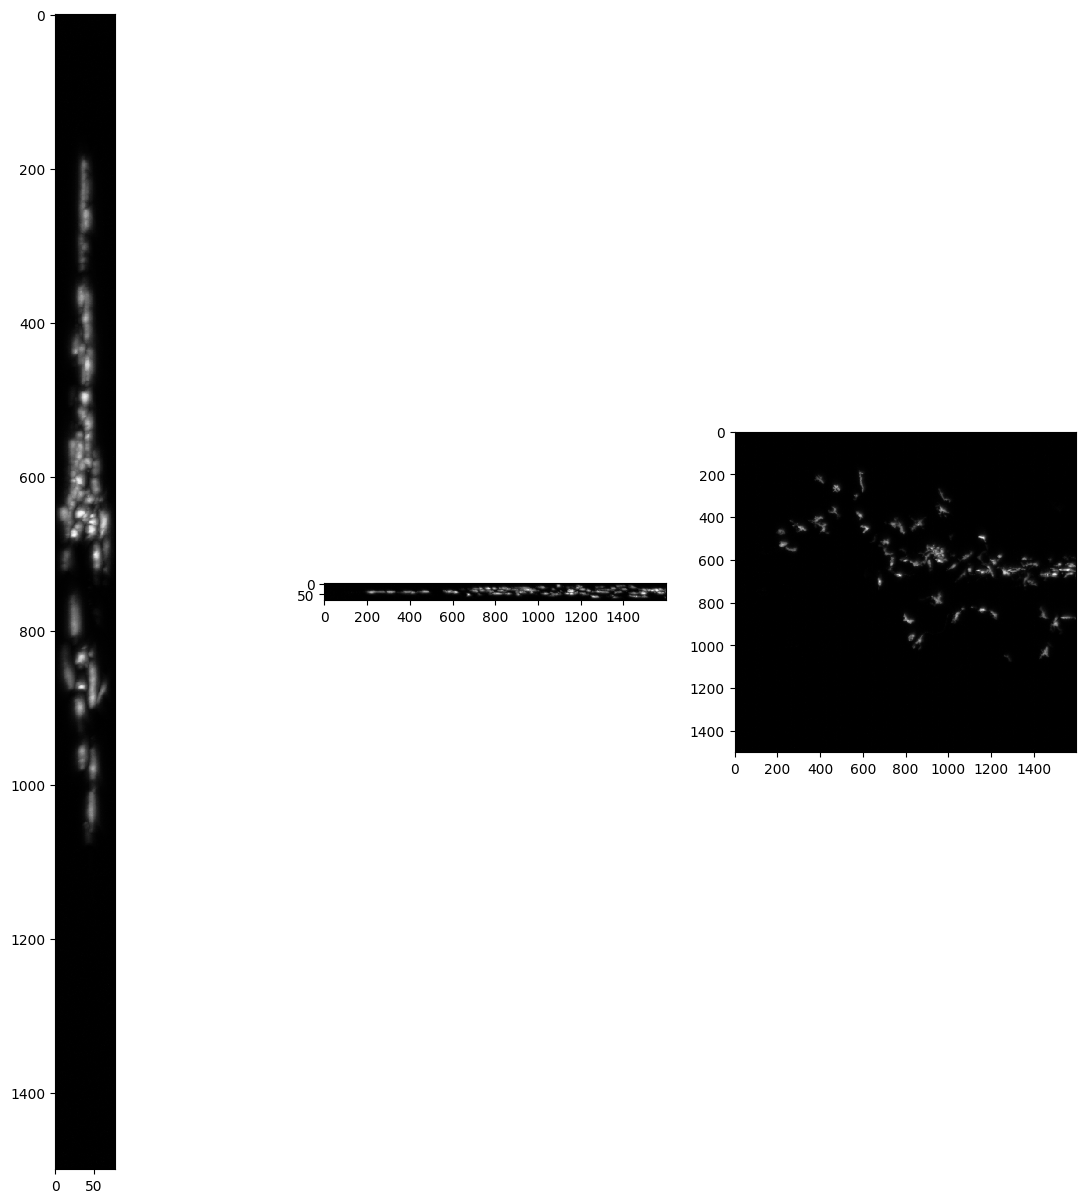

In [4]:
# Select 3D volume: channel 0, timepoint 1
vol_raw = raw_data[1, 0]  # shape [C, T, Z, Y, X]

# Push to GPU (CLE object)
gpu_raw = cle.push(vol_raw)

# We can start by looking at intensity projections along each axis
show(gpu_raw)

As seen from the metadata, voxels are anisotropic so we can scale the image to get a stack with isotropic voxels

In [ ]:


voxel_size_z, voxel_size_y, voxel_size_x = voxel_size[-3:]

iso_data = cle.scale(gpu_raw, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, auto_size=True)

#viewer.add_image(iso_data, name=f'Rescaled data t={timepoint}', colormap='gray')



Next we can check for any intesity decay in the z-axis that should be corrected

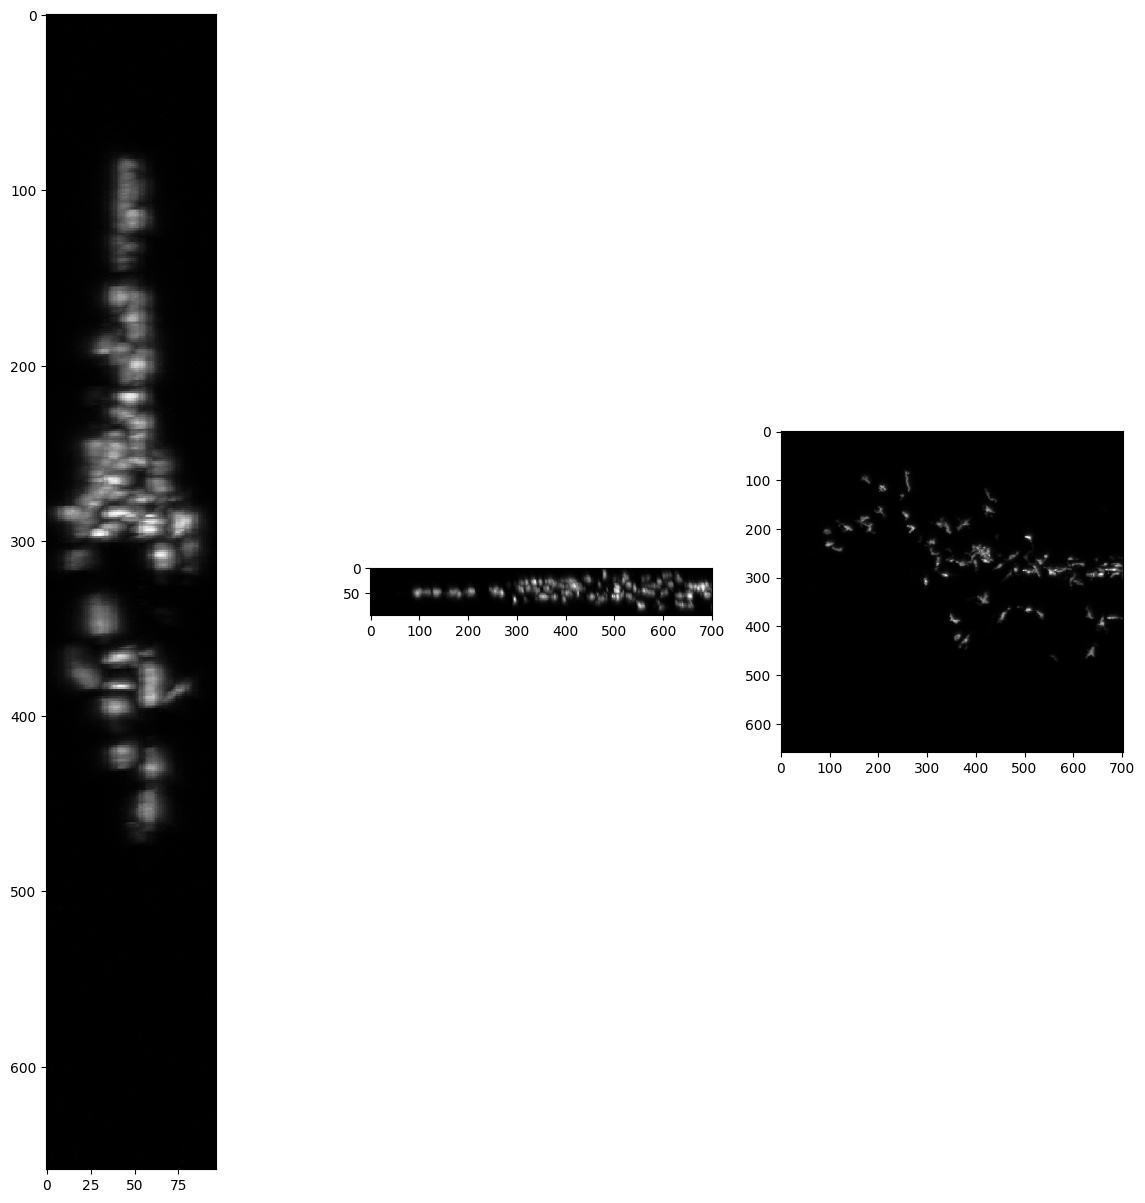

In [6]:
show(iso_data)

In [7]:
viewer.add_image(iso_data, name=f'Iso data t={timepoint}', colormap='gray')

<Image layer 'Iso data t=0' at 0x14d9da5d0>

Seems pretty good (makes sense as data is from light sheet microscope), no intensity correction decay needed

### Normalization

Before choosing our normalization method we will start by checking the properties of the image (histogram of pixel values)

[[[1. 1. 2. ... 3. 1. 0.]
  [0. 0. 3. ... 0. 0. 0.]
  [0. 0. 2. ... 0. 1. 1.]
  ...
  [4. 0. 1. ... 3. 1. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[4. 0. 1. ... 1. 1. 1.]
  [3. 0. 3. ... 0. 3. 0.]
  [0. 1. 9. ... 0. 0. 1.]
  ...
  [2. 1. 0. ... 1. 1. 0.]
  [1. 2. 1. ... 1. 0. 5.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[4. 1. 3. ... 1. 1. 0.]
  [0. 0. 1. ... 1. 2. 0.]
  [0. 0. 5. ... 1. 1. 1.]
  ...
  [0. 1. 3. ... 0. 1. 0.]
  [0. 0. 0. ... 3. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 1. 0. ... 1. 1. 1.]
  [1. 3. 1. ... 0. 0. 0.]
  [0. 2. 0. ... 1. 1. 0.]
  ...
  [3. 1. 0. ... 0. 1. 2.]
  [1. 0. 1. ... 1. 4. 2.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 3. 0. ... 0. 1. 2.]
  [0. 1. 1. ... 0. 1. 0.]
  [3. 1. 0. ... 3. 3. 1.]
  ...
  [0. 4. 0. ... 0. 1. 1.]
  [0. 2. 0. ... 0. 3. 1.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 3. 0. ... 0. 1. 2.]
  [0. 1. 1. ... 0. 1. 0.]
  [3. 1. 0. ... 3. 3. 1.]
  ...
  [0. 4. 0. ... 0. 1. 1.]
  [0. 2. 0. ... 0. 3. 1.]
  [0. 0. 0. ... 0. 0. 0.]]]
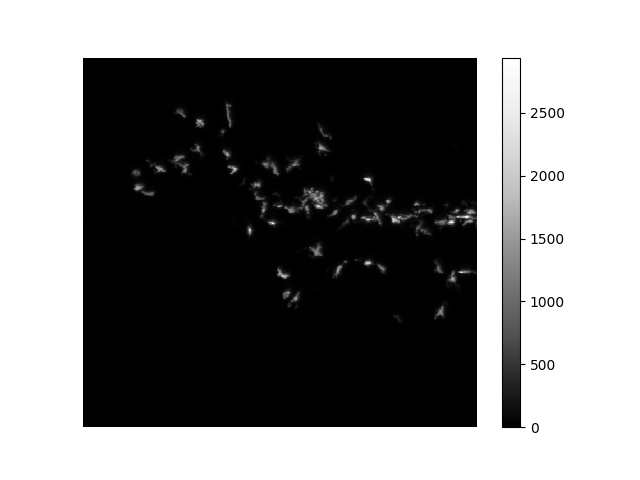
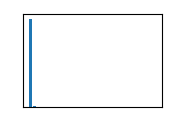

In [8]:
insight(iso_data)

We can immediately see that the pixel values are highly skewed (outlier/hot pixel). This leads to a lack in contrast (even though the raw data looks quite okay). Methods such as min-max normalization are highly sensitive to these outliers- Z-score normalization could work but doesn't perform well with non Gaussian data percentile based normalization would be a better choice in our case.

[[[0.00149925 0.00149925 0.0029985  ... 0.00449775 0.00149925 0.        ]
  [0.         0.         0.00449775 ... 0.         0.         0.        ]
  [0.         0.         0.0029985  ... 0.         0.00149925 0.00149925]
  ...
  [0.005997   0.         0.00149925 ... 0.00449775 0.00149925 0.        ]
  [0.         0.00149925 0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.005997   0.         0.00149925 ... 0.00149925 0.00149925 0.00149925]
  [0.00449775 0.         0.00449775 ... 0.         0.00449775 0.        ]
  [0.         0.00149925 0.01349325 ... 0.         0.         0.00149925]
  ...
  [0.0029985  0.00149925 0.         ... 0.00149925 0.00149925 0.        ]
  [0.00149925 0.0029985  0.00149925 ... 0.00149925 0.         0.00749625]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.005997   0.00149925 0.00449775 ... 0.00149925 0.00149925 0.        ]
  [0.         0.         0.00149925 ... 0.00149925 0.0029985  0.        ]
  [0.         0.         0.00749625 ... 0.00149925 0.00149925 0.00149925]
  ...
  [0.         0.00149925 0.00449775 ... 0.         0.00149925 0.        ]
  [0.         0.         0.         ... 0.00449775 0.         0.00149925]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 ...

 [[0.         0.00149925 0.         ... 0.00149925 0.00149925 0.00149925]
  [0.00149925 0.00449775 0.00149925 ... 0.         0.         0.        ]
  [0.         0.0029985  0.         ... 0.00149925 0.00149925 0.        ]
  ...
  [0.00449775 0.00149925 0.         ... 0.         0.00149925 0.0029985 ]
  [0.00149925 0.         0.00149925 ... 0.00149925 0.005997   0.0029985 ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.00149925 0.00449775 0.         ... 0.         0.00149925 0.0029985 ]
  [0.         0.00149925 0.00149925 ... 0.         0.00149925 0.        ]
  [0.00449775 0.00149925 0.         ... 0.00449775 0.00449775 0.00149925]
  ...
  [0.         0.005997   0.         ... 0.         0.00149925 0.00149925]
  [0.         0.0029985  0.         ... 0.         0.00449775 0.00149925]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.00149925 0.00449775 0.         ... 0.         0.00149925 0.0029985 ]
  [0.         0.00149925 0.00149925 ... 0.         0.00149925 0.        ]
  [0.00449775 0.00149925 0.         ... 0.00449775 0.00449775 0.00149925]
  ...
  [0.         0.005997   0.         ... 0.         0.00149925 0.00149925]
  [0.         0.0029985  0.         ... 0.         0.00449775 0.00149925]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
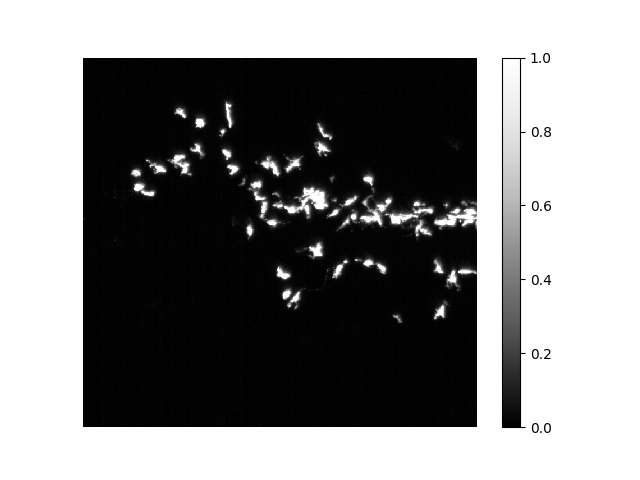
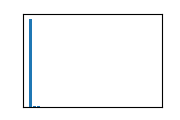

In [9]:
# Compute percentiles
p1 = np.percentile(iso_data, 0.1)
p99 = np.percentile(iso_data, 99.9)

# Perform percentile normalization
percentile_image_unclipped = (iso_data - p1) / (p99 - p1)
normalized_data = np.clip(percentile_image_unclipped, 0, 1)  
insight(normalized_data)

In [21]:
viewer.add_image(normalized_data, name=f'Normalized data t={timepoint}', colormap='gray')

<Image layer 'Normalized data t=0' at 0x151753ed0>

### B. 3D Instance Segmentation:
 	
One of the larger goals of our team is to fully map the dynamics of all the immune cells in such microscopy datasets. The first step is to segment the objects of interest. Use 3 approaches that will work well for this specific dataset to generate 3D instance based segmentation of immune cells for each timepoint. What are the merits of one approach over the other and which approach worked best according to you and why? If you decide to explore approaches with GPU usage, google collab provides free GPU credits. 

Discuss what approaches could you use to remove other objects that are in the images that get segmented out that aren’t true signal i.e. immune cells.


### Approach 1 Voronoi-Otsu-Labelling


In [30]:
gpu_vol = cle.push(normalized_data)

# Background denoising (doesn't seem necessary for now)
# gpu_vol = cle.gaussian_blur(gpu_vol, sigma_x=1, sigma_y=1, sigma_z=0.5)

# Watershed
labels = cle.voronoi_otsu_labeling(gpu_vol, spot_sigma=5.0, outline_sigma=1)   # Choose spot sigma as how close detected cells can be (I measured in napari)
                                                                                # Outline precision (we want it low as some of the cells branch out)

print("✅ Segmentation complete")
print("Number of objects detected:", np.max(labels))


size: 97
✅ Segmentation complete
Number of objects detected: 70.0


In [20]:
viewer.add_labels(cle.pull(labels),  name=f'Voronoi-Otsu labels t={timepoint}')

<Labels layer 'Voronoi-Otsu labels t=0' at 0x171e88e10>

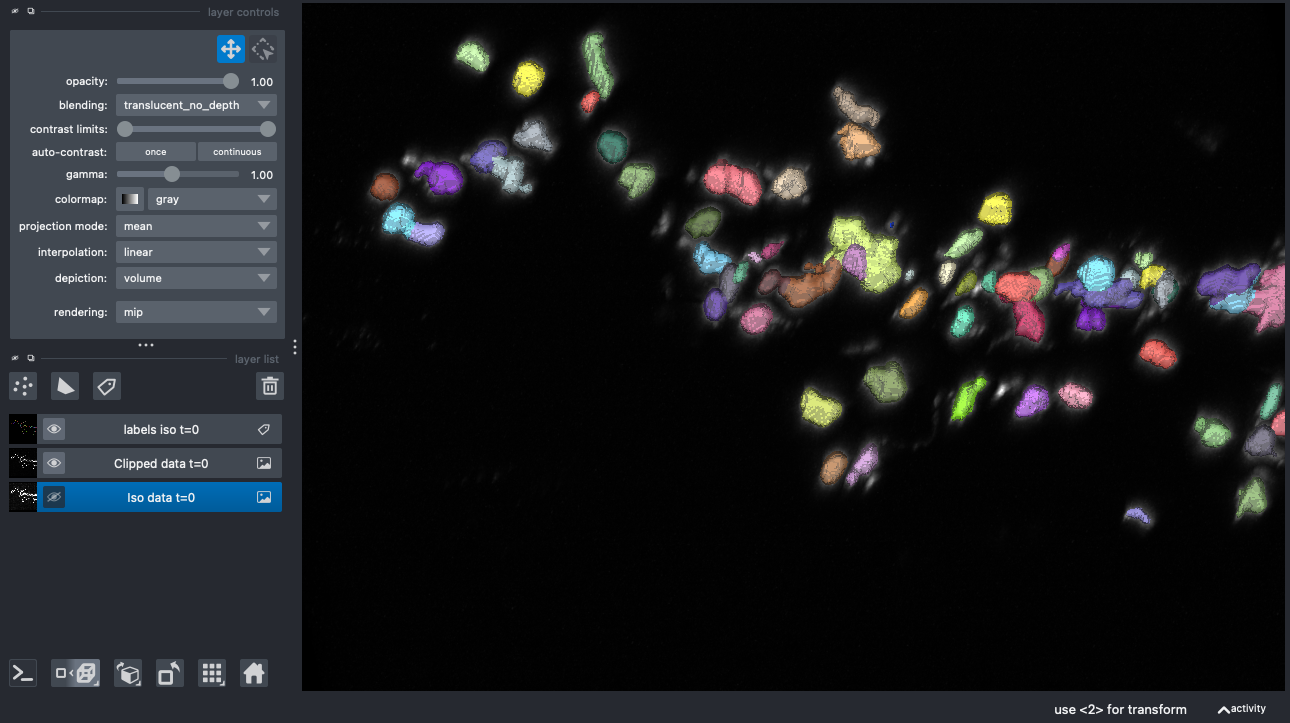

In [15]:
nbscreenshot(viewer)

We can see that the Voronoi-Otsu-Labelling method performs pretty well. However some of the protrusions of certain cells are ignored. Also very small object that most likely are not cells are being detected. We can also notice touching objects that have a very strict boundary, not reflecting correctly their morphological nature. To solve these problems, we can select segmented objects based on their size/morphology (ferret diameter, eccentricity, solidity),  This method lacks precision but is simple and fast, good for prototyping. Furthermore, parameter optimization could be applied to improve results

### Approach 2 Machine learning

In [16]:
from sklearn.ensemble import RandomForestClassifier
from skimage import filters
from skimage.io import imread, imshow


the next code cell can be skipped unless you want to retrain the classifier

In [ ]:

from magicgui import magicgui
import pyclesperanto_prototype as cle
import apoc
import os

# ------------------
# Load your volume (preprocessed / normalized)
# ------------------
# Example: replace this with your volume
vol = gpu_vol  # shape: (Z,Y,X)

# ------------------
# Napari Viewer
# ------------------
viewer = napari.Viewer()
viewer.add_image(vol, name="raw")

# Add empty label layer for manual annotation
label_layer = viewer.add_labels(np.zeros_like(vol, dtype=np.uint8), name="annotations")

# ------------------
# Classifier save path
# ------------------
cl_filename = 'segmenter.cl'

# ------------------
# Feature set
# ------------------
features = apoc.PredefinedFeatureSet.small_quick.value

# ------------------
# Train & Predict function
# ------------------
def train_and_predict():
    manual_annotations = label_layer.data
    
    if np.count_nonzero(manual_annotations) < 10:
        print("⚠️ Not enough annotations to train.")
        return

    # Erase previous classifier if exists
    apoc.erase_classifier(cl_filename)

    # Create ObjectSegmenter
    clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)

    # Train
    clf.train(features, manual_annotations, vol)
    print(f"✅ Classifier trained and saved at {cl_filename}")

    # Predict segmentation
    segmentation = clf.predict(vol)

    # Add/update segmentation layer
    if "segmentation" in viewer.layers:
        viewer.layers["segmentation"].data = segmentation
    else:
        viewer.add_labels(segmentation.astype(np.uint8), name="segmentation")

    print("✅ Segmentation updated in napari")

# ------------------
# Load and Predict function
# ------------------
def load_and_predict():
    if not os.path.exists(cl_filename):
        print(f"⚠️ No classifier found at {cl_filename}")
        return

    clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
    segmentation = clf.predict(vol)

    if "segmentation" in viewer.layers:
        viewer.layers["segmentation"].data = segmentation
    else:
        viewer.add_labels(segmentation.astype(np.uint8), name="segmentation")

    print(f"✅ Segmentation done using classifier from {cl_filename}")

# ------------------
# Add buttons in napari
# ------------------
@magicgui(call_button="Train Classifier")
def train_button():
    train_and_predict()

@magicgui(call_button="Load Classifier")
def load_button():
    load_and_predict()

viewer.window.add_dock_widget(train_button, area="right")
viewer.window.add_dock_widget(load_button, area="right")

# ------------------
# Start napari
# ------------------
napari.run()


In [ ]:

# Imports
import os
import apoc
from scipy import ndimage as ndi
import napari_segment_blobs_and_things_with_membranes as nsbatwm


# Path to saved classifier

cl_filename = 'segmenter.cl'
if not os.path.exists(cl_filename):
    raise FileNotFoundError(f"No classifier found at {cl_filename}")

# Load classifier

clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)

# Predict rough segmentation
rough_seg = clf.predict(gpu_vol)

# The classifier has a hard time distinguishing between close cells, therefore I chose a hybrid 
# approach to split touching objects after segmentation

refined_seg = nsbatwm.split_touching_objects(rough_seg, sigma=3)    # sigma was chosen in a way that the segmentation made sense when overlapped to the stack

ml_labels = cle.connected_components_labeling_diamond(refined_seg)


print("✅ Segmentation complete")
print("Number of objects detected:", np.max(ml_labels))


✅ Segmentation complete
Number of objects detected: 73.0


In [ ]:
viewer.add_labels(cle.pull(ml_labels),  name=f'ml labels t={timepoint}')
#viewer.add_labels(cle.pull(rough_seg),  name=f'rough labels t={timepoint}')

<Labels layer 'rough labels t=0' at 0x17c75fd90>

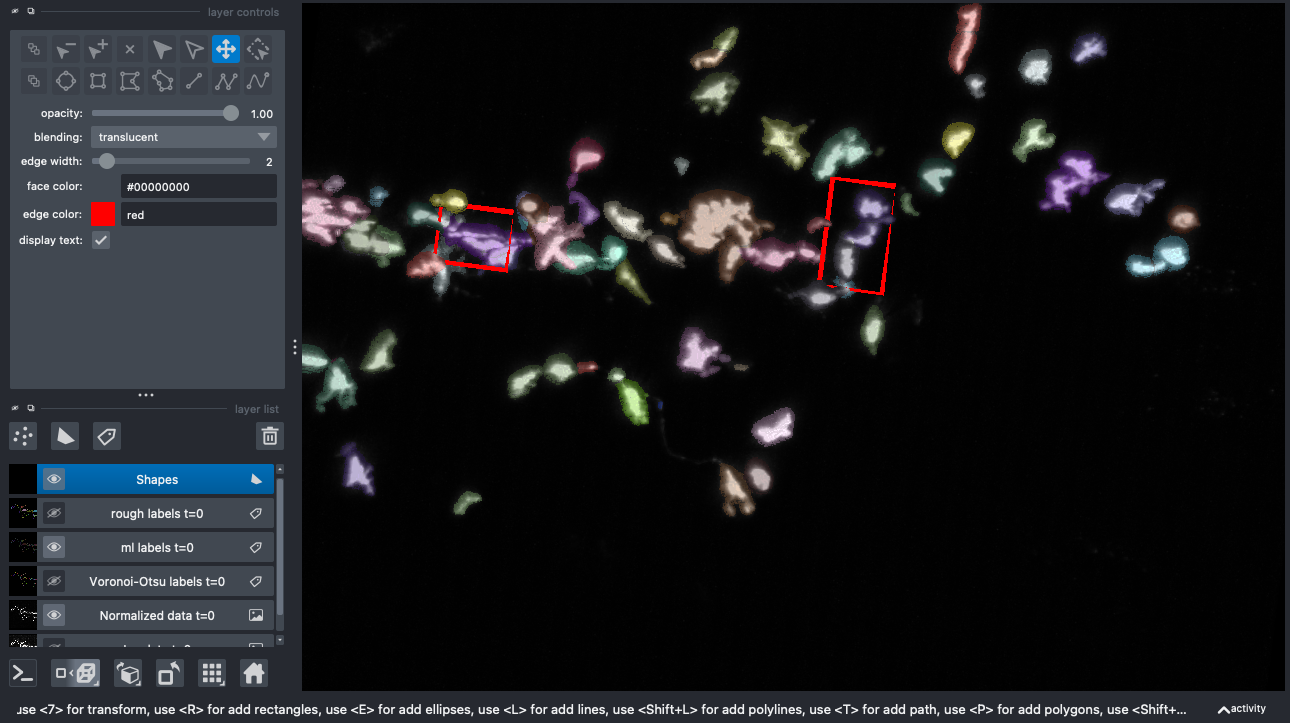

In [33]:
nbscreenshot(viewer)

The number of detected objects is similar to that of the Voronoi-Otsu method. However, we still see very small objects detected as well as small clusters of cells that are counted as one whole cell. Unless they are part of the cell and the fluorescent marker is unevenly expressed throughout the cell body Trying other feature maps could improve the results. -> Checking the homogeneity of the marker's expression throughout the cells would help to fine tune the sigmas and other parameters. For now I'm more or less guessing what a cell is supposed to look like 

### Approach 3 Deep Learning with cellpose/stardist

In [59]:
from tqdm import tqdm
from cellpose import models
from skimage.transform import resize
import numpy as np

# Add channel axis: (Z, 1, Y, X)
imgs = normalized_data[:, None, :, :]
print("Original shape:", imgs.shape)

# Downsample in XY (factor 2)
factor = 10
imgs_small = np.array([
    resize(imgs[z,0], 
           (imgs.shape[2]//factor, imgs.shape[3]//factor), 
           preserve_range=True, 
           anti_aliasing=True) 
    for z in range(imgs.shape[0])
], dtype=np.float32)

# Back to (Z, 1, Y, X)
imgs_small = imgs_small[:, None, :, :]
print("Downsampled shape:", imgs_small.shape)

# Initialize Cellpose model (you can also try 'nuclei' or 'cyto')
model = models.CellposeModel(gpu=False, model_type='cyto2')

# Run slice-by-slice with progress bar
masks_all = []
for z in tqdm(range(imgs_small.shape[0]), desc="Cellpose Z-slices"):
    mask, flows, styles = model.eval(
        imgs_small[z], 
        diameter=None, 
        channels=[0,0], 
        do_3D=False
    )
    masks_all.append(mask)

# Stack masks back into 3D
masks = np.stack(masks_all, axis=0)
print("Mask stack shape:", masks.shape)


Original shape: (97, 1, 659, 702)


model_type argument is not used in v4.0.1+. Ignoring this argument...


Downsampled shape: (97, 1, 65, 70)


Cellpose Z-slices: 100%|██████████| 97/97 [36:57<00:00, 22.86s/it]

Mask stack shape: (97, 65, 70)


In [ ]:
from tqdm import tqdm

imgs = normalized_data
chunk_size = 16
masks_all = []
for start in tqdm(range(0, imgs.shape[0], chunk_size), desc="Cellpose chunks"):
    end = min(start + chunk_size, imgs.shape[0])
    chunk = imgs[start:end]
    masks_chunk, flows, styles = model.eval(chunk, diameter=None, z_axis=0, channel_axis=1, do_3D= True)

    masks_all.append(masks_chunk)

masks = np.concatenate(masks_all, axis=0)


Cellpose chunks:   0%|          | 0/7 [01:08<?, ?it/s]


KeyboardInterrupt: 

/Users/quillan/anaconda3/envs/interview/lib/python3.13/site-packages/pyclesperanto_prototype/_tier9/_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


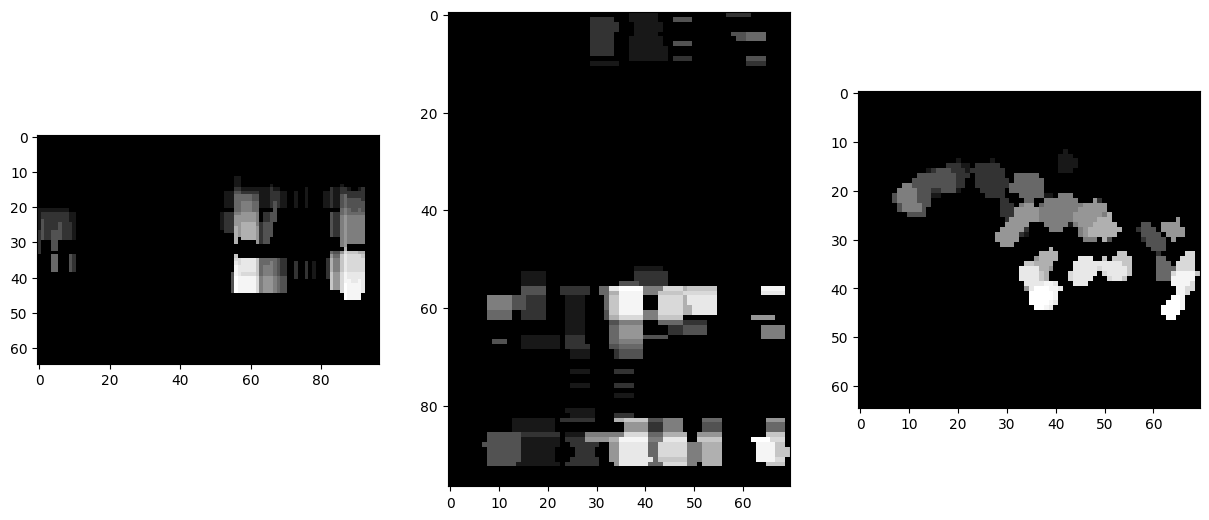

In [60]:
show(masks)

In [ ]:
viewer.add_labels(masks,  name=f'cellpose labels t={timepoint}')

ValueError: Input data should be an array-like object, or a sequence of arrays of decreasing size. Got arrays of single size: 1

### BONUS:

How much time does it take to run your segmentation pipelines on these data?  Are there ways you could parallelize processing? 



### C. Feature Extraction:

Generate a csv file of each segmented object's label and a list of properties that describe their location and shape in the image. There are many possibilities for features and you can choose as many as you deem useful. Let us know which features you think could be good to use in a future object classifier. 



In [ ]:
import numpy as np
import pandas as pd
from skimage.measure import regionprops
from scipy.spatial import ConvexHull
import pyclesperanto_prototype as cle

def extract_3d_geometry_features(labels, voxel_size=1.0, csv_path="immune_cell_features_3d_geometry.csv"):
    """
    Extract 3D geometric features for segmented objects with physical units.
    
    Parameters
    ----------
    labels : np.ndarray or pyclesperanto GPU array
        3D labeled segmentation array (integer labels, 0=background)
    voxel_size : float or tuple of 3 floats
        Size of a voxel in physical units (z, y, x). If single float, isotropic.
    csv_path : str
        Path to save the CSV file with features
    
    Returns
    -------
    df : pd.DataFrame
        DataFrame with all extracted features
    """
    # Ensure labels are CPU NumPy array
    if "cle" in str(type(labels)):
        labels = cle.pull(labels)
    labels = labels.astype(np.int32)
    
    # Convert voxel_size to tuple
    if np.isscalar(voxel_size):
        voxel_size = (voxel_size, voxel_size, voxel_size)
    voxel_volume = np.prod(voxel_size)
    
    labels_ids = np.unique(labels)
    labels_ids = labels_ids[labels_ids != 0]  # skip background
    
    rows = []
    
    major_axis, intermediate_axis, minor_axis = [], [], []
    elongation1, elongation2 = [], []
    sphericity_list = []
    
    for lbl in labels_ids:
        mask = (labels == lbl).astype(np.uint8)
        region = regionprops(mask)[0]
        coords = np.argwhere(mask)
        
        # Basic properties (convert to physical units)
        centroid = np.array(region.centroid) * voxel_size
        bbox = np.array(region.bbox) * np.tile(voxel_size, 2)  # min/max_z/y/x
        
        area = region.area * voxel_volume  # number of voxels in label x volume per voxel (yes the variable name is not well chosen)
        solidity = region.solidity
        extent = region.extent
        
        # PCA axes
        if coords.shape[0] >= 3:
            coords_phys = coords * voxel_size
            cov = np.cov(coords_phys, rowvar=False)
            evals, _ = np.linalg.eigh(cov)
            evals = np.sort(evals)[::-1]
            axes = 4 * np.sqrt(evals)
            major_axis.append(axes[0])
            intermediate_axis.append(axes[1])
            minor_axis.append(axes[2])
            elongation1.append(axes[1]/axes[0])
            elongation2.append(axes[2]/axes[0])
        else:
            major_axis.append(np.nan)
            intermediate_axis.append(np.nan)
            minor_axis.append(np.nan)
            elongation1.append(np.nan)
            elongation2.append(np.nan)
        
        # Sphericity using convex hull (coords already in voxel units, shape ratio unaffected by scaling)
        try:
            hull = ConvexHull(coords)
            surface_area = hull.area
            volume = coords.shape[0]
            sphericity_list.append((np.pi**(1/3))*(6*volume)**(2/3)/surface_area)
        except:
            sphericity_list.append(np.nan)
        
        rows.append({
            "label": lbl,
            "volume": area, # volume in voxels
            "volume": area, # volume in voxels
            "centroid_z": centroid[0],
            "centroid_y": centroid[1],
            "centroid_x": centroid[2],
            "bbox_min_z": bbox[0],
            "bbox_min_y": bbox[1],
            "bbox_min_x": bbox[2],
            "bbox_max_z": bbox[3],
            "bbox_max_y": bbox[4],
            "bbox_max_x": bbox[5],
            "solidity": solidity,
            "extent": extent
        })
    
    df = pd.DataFrame(rows)
    
    # Add PCA/sphericity features
    df["major_axis"] = major_axis
    df["intermediate_axis"] = intermediate_axis
    df["minor_axis"] = minor_axis
    df["elongation_ratio1"] = elongation1
    df["elongation_ratio2"] = elongation2
    df["sphericity"] = sphericity_list
    
    # Save CSV
    df.to_csv(csv_path, index=False)
    print(f"Saved {len(df)} objects with 3D geometry features (physical units) to {csv_path}")
    
    return df


In [82]:
otsu_features_df = extract_3d_geometry_features(labels, voxel_size=voxel_size[-1], csv_path="otsu_features.csv")
ml_features_df = extract_3d_geometry_features(ml_labels, voxel_size=voxel_size[-1],csv_path="ml_features.csv")

Saved 70 objects with 3D geometry features (physical units) to otsu_features.csv
Saved 73 objects with 3D geometry features (physical units) to ml_features.csv


### BONUS:

How much time does it take to run your segmentation pipelines on these data?  Are there ways you could parallelize processing? 

### C. Feature Extraction:

Generate a csv file of each segmented object's label and a list of properties that describe their location and shape in the image. There are many possibilities for features and you can choose as many as you deem useful. Let us know which features you think could be good to use in a future object classifier. 

### D.Visualization:

Generate a nice visualization of a few of your instances as a movie or pngs. You could use napari on any software that you are familiar with to do this. Pick 2-3 features from your csv list and overlay them on the visual of the instance. 

### E. Tracking (BONUS)

Using any tracking algorithm of your choice, track the immune cells that are in these images. What were your learnings from this? What challenges did you face and what seemed to work well for this dataset? Share your results on this process. 
 
### F. Biological insights

What interesting biological questions do you think this dataset can give us some insight into? Propose the question and a brief sketch (a few sentences) on how you could use this dataset to measure/answer that question.
